# Exploring Trends in Most Populous Cities of the United States

### Introduction

Company X wishes to branch out their business chain by opening new locations in ideal US cities. To identify which US cities might be ideal candidates as well as ideal locations within those cities; we explore relationships between the most populous US cities and the types of venues that correspond to each. We will then perform agglomerative hierarchical clustering to see which of the top 300 or so most populous US cities might be worthy of looking into further. The hierarchical clustering will be based on population, population change (percent increase/decrease), and the 100 top-rated types of venues that exist within them (near the city centers). Once the hierarchical clustering is completed, a more in-depth study can then be performed by Company X. Therefore, this work is a preliminary investigation step.

### Data Collection

To start with, we scrape Wikipedia's page for the list of most populous US cities with their corresponding percent-increase/percent-decrease:

https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population

Then, using this initial data set with the corresponding GPS locations (included in the data table), we will obtain venues using the Foursquare API and investigate the trending venues.

I perform the scrape below.

### Importing Libraries:

In [1]:
# import necessary libraries

# import numpy
import numpy as np

# import pandas
import pandas as pd

# import web scraping tools
from urllib.request import urlopen
from bs4 import BeautifulSoup

# library to handle JSON files
import json

# import geocoder
import geocoder

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim

# import folium for maps
import folium

# library to handle requests
import requests

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [2]:
def get_html_contents(page_url):
    results = requests.get(page_url) # access url location
    soup = BeautifulSoup(results.text,'html.parser') # parse through html of url and store page info
    return soup
    
cities_url = 'https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population' # define desired url

cities_contents = get_html_contents(cities_url)

In [3]:
city_pop_table = cities_contents.find('table', {'class': 'wikitable sortable'}) # find the first table of class 'wikitable sortable'
city_pop_header = city_pop_table.tr.find_all('th') # create html table headers list

column_names = [] # create empty list

for header in city_pop_header:
    column_names.append(header.text.strip().replace(',','_')) # collects column names as list
print(column_names)

['2020rank', 'City', 'State[c]', '2020estimate', '2010census', 'Change', '2016 land area', '2016 population density', 'Location']


In [4]:
file_name = 'us_cities_data_2020.csv' # give name to file

f = open(file_name,'w+', encoding='utf-8') # open file to store web scraped data

for i in range(len(column_names)): # write to file all column names as header to file
    if column_names[i] != column_names[-1]:
        f.write(column_names[i] + ',')
    else:
        f.write(column_names[i] + '\n')

table_rows = city_pop_table.find_all('tr') # list of all tr

for row in table_rows: # grab data from each cell and write to file
    cells = row.find_all('td')
    if len(cells) > 1:
        for i, cell in enumerate(cells):
            cell_data = cell.text.strip().replace(',','')
            if cells[i] != cells[-1]:
                if i == 7 or i == 9: # ignore metric units
                # assuming this is an American company so English units are desired
                    continue
                f.write(cell_data + ',')
            else:
                f.write(cell_data + '\n')
                    
f.close() # be sure to close the file!!!

In [5]:
us_cities_df = pd.read_csv('us_cities_data_2020.csv') # read csv file to obtain dataframe
us_cities_df.head() # take a peak at dataframe

,2020rank,City,State[c],2020estimate,2010census,Change,2016 land area,2016 population density,Location
0,1,New York[d],New York,8253213,8175133,+0.96%,301.5 sq mi,28317/sq mi,40°40′N 73°56′W﻿ / ﻿40.66°N 73.93°W﻿ / 40.66; ...
1,2,Los Angeles,California,3970219,3792621,+4.68%,468.7 sq mi,8484/sq mi,34°01′N 118°25′W﻿ / ﻿34.01°N 118.41°W﻿ / 34.01...
2,3,Chicago,Illinois,2677643,2695598,−0.67%,227.3 sq mi,11900/sq mi,41°50′N 87°41′W﻿ / ﻿41.83°N 87.68°W﻿ / 41.83; ...
3,4,Houston,Texas,2316120,2100263,+10.28%,637.5 sq mi,3613/sq mi,29°47′N 95°23′W﻿ / ﻿29.78°N 95.39°W﻿ / 29.78; ...
4,5,Phoenix,Arizona,1708127,1445632,+18.16%,517.6 sq mi,3120/sq mi,33°34′N 112°05′W﻿ / ﻿33.57°N 112.09°W﻿ / 33.57...


### Data Cleaning:

In [6]:
cities_cleaned = [] # initialize an empty list

for i, text in enumerate(us_cities_df.index): # cleans city names and appends to list
    cities_cleaned.append(us_cities_df.loc[i,'City'].split('[')[0])
    
print(cities_cleaned) # take a peak

['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix', 'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'San Jose', 'Austin', 'Fort Worth', 'Jacksonville', 'Columbus', 'Charlotte', 'Indianapolis', 'San Francisco', 'Seattle', 'Denver', 'Washington', 'Boston', 'El Paso', 'Nashville', 'Detroit', 'Las Vegas', 'Oklahoma City', 'Portland', 'Memphis', 'Louisville', 'Milwaukee', 'Baltimore', 'Albuquerque', 'Tucson', 'Fresno', 'Mesa', 'Sacramento', 'Atlanta', 'Kansas City', 'Colorado Springs', 'Omaha', 'Raleigh', 'Miami', 'Long Beach', 'Virginia Beach', 'Minneapolis', 'Oakland', 'Tampa', 'Tulsa', 'Arlington', 'Wichita', 'New Orleans', 'Aurora', 'Bakersfield', 'Cleveland', 'Anaheim', 'Honolulu', 'Santa Ana', 'Riverside', 'Henderson', 'Corpus Christi', 'Lexington', 'Stockton', 'Saint Paul', 'Cincinnati', 'Pittsburgh', 'Greensboro', 'St. Louis', 'Plano', 'Lincoln', 'Orlando', 'Anchorage', 'Durham', 'Irvine', 'Newark', 'Chula Vista', 'Fort Wayne', 'Toledo', 'St. Petersburg', 'Chandler', 

In [7]:
us_cities_df['City'] = pd.Series(cities_cleaned) # repleace 'City' column with newly cleaned names
us_cities_df.head()

,2020rank,City,State[c],2020estimate,2010census,Change,2016 land area,2016 population density,Location
0,1,New York,New York,8253213,8175133,+0.96%,301.5 sq mi,28317/sq mi,40°40′N 73°56′W﻿ / ﻿40.66°N 73.93°W﻿ / 40.66; ...
1,2,Los Angeles,California,3970219,3792621,+4.68%,468.7 sq mi,8484/sq mi,34°01′N 118°25′W﻿ / ﻿34.01°N 118.41°W﻿ / 34.01...
2,3,Chicago,Illinois,2677643,2695598,−0.67%,227.3 sq mi,11900/sq mi,41°50′N 87°41′W﻿ / ﻿41.83°N 87.68°W﻿ / 41.83; ...
3,4,Houston,Texas,2316120,2100263,+10.28%,637.5 sq mi,3613/sq mi,29°47′N 95°23′W﻿ / ﻿29.78°N 95.39°W﻿ / 29.78; ...
4,5,Phoenix,Arizona,1708127,1445632,+18.16%,517.6 sq mi,3120/sq mi,33°34′N 112°05′W﻿ / ﻿33.57°N 112.09°W﻿ / 33.57...


In [8]:
location_cleaned = [] # initialize empty list

for i, content in enumerate(us_cities_df.index): # cleaning location lat/long coords
    location_cleaned.append(us_cities_df.loc[i,'Location'].replace('\ufeff','').split('/')[2].split('(')[0].replace(' ',''))
    
lat_coords = [] # initialize
long_coords = [] # initialize

for i, text in enumerate(location_cleaned): # separate lat and long coords into separate lists
    lat, long = location_cleaned[i].split(';')
    lat_coords.append(lat)
    long_coords.append(long)

us_cities_df['Lat'] = pd.Series(lat_coords).astype(float) # add column for latidude
us_cities_df['Long'] = pd.Series(long_coords).astype(float) # add column for longitude
us_cities_df.head() # take a peak

,2020rank,City,State[c],2020estimate,2010census,Change,2016 land area,2016 population density,Location,Lat,Long
0,1,New York,New York,8253213,8175133,+0.96%,301.5 sq mi,28317/sq mi,40°40′N 73°56′W﻿ / ﻿40.66°N 73.93°W﻿ / 40.66; ...,40.66,-73.93
1,2,Los Angeles,California,3970219,3792621,+4.68%,468.7 sq mi,8484/sq mi,34°01′N 118°25′W﻿ / ﻿34.01°N 118.41°W﻿ / 34.01...,34.01,-118.41
2,3,Chicago,Illinois,2677643,2695598,−0.67%,227.3 sq mi,11900/sq mi,41°50′N 87°41′W﻿ / ﻿41.83°N 87.68°W﻿ / 41.83; ...,41.83,-87.68
3,4,Houston,Texas,2316120,2100263,+10.28%,637.5 sq mi,3613/sq mi,29°47′N 95°23′W﻿ / ﻿29.78°N 95.39°W﻿ / 29.78; ...,29.78,-95.39
4,5,Phoenix,Arizona,1708127,1445632,+18.16%,517.6 sq mi,3120/sq mi,33°34′N 112°05′W﻿ / ﻿33.57°N 112.09°W﻿ / 33.57...,33.57,-112.09


In [9]:
us_cities_df.drop('Location',axis=1,inplace=True) # drop messy location column
us_cities_df.head()

,2020rank,City,State[c],2020estimate,2010census,Change,2016 land area,2016 population density,Lat,Long
0,1,New York,New York,8253213,8175133,+0.96%,301.5 sq mi,28317/sq mi,40.66,-73.93
1,2,Los Angeles,California,3970219,3792621,+4.68%,468.7 sq mi,8484/sq mi,34.01,-118.41
2,3,Chicago,Illinois,2677643,2695598,−0.67%,227.3 sq mi,11900/sq mi,41.83,-87.68
3,4,Houston,Texas,2316120,2100263,+10.28%,637.5 sq mi,3613/sq mi,29.78,-95.39
4,5,Phoenix,Arizona,1708127,1445632,+18.16%,517.6 sq mi,3120/sq mi,33.57,-112.09


In [10]:
us_cities_df.rename(columns={'2020rank': '2020 Rank',
                             'State[c]': 'State',
                             '2020estimate': '2020 Estimate',
                             '2010census': '2010 Census',
                             '2016 land area': 'Land Area (sq mi)',
                             '2016 population density': 'Population Density (per sq mi)'},
                    inplace=True) # renaming columns for cleaner look and easier use
us_cities_df.head()

,2020 Rank,City,State,2020 Estimate,2010 Census,Change,Land Area (sq mi),Population Density (per sq mi),Lat,Long
0,1,New York,New York,8253213,8175133,+0.96%,301.5 sq mi,28317/sq mi,40.66,-73.93
1,2,Los Angeles,California,3970219,3792621,+4.68%,468.7 sq mi,8484/sq mi,34.01,-118.41
2,3,Chicago,Illinois,2677643,2695598,−0.67%,227.3 sq mi,11900/sq mi,41.83,-87.68
3,4,Houston,Texas,2316120,2100263,+10.28%,637.5 sq mi,3613/sq mi,29.78,-95.39
4,5,Phoenix,Arizona,1708127,1445632,+18.16%,517.6 sq mi,3120/sq mi,33.57,-112.09


In [11]:
us_cities_df.drop('2020 Rank',axis=1,inplace=True) # rank unnecessary
us_cities_df.head()

,City,State,2020 Estimate,2010 Census,Change,Land Area (sq mi),Population Density (per sq mi),Lat,Long
0,New York,New York,8253213,8175133,+0.96%,301.5 sq mi,28317/sq mi,40.66,-73.93
1,Los Angeles,California,3970219,3792621,+4.68%,468.7 sq mi,8484/sq mi,34.01,-118.41
2,Chicago,Illinois,2677643,2695598,−0.67%,227.3 sq mi,11900/sq mi,41.83,-87.68
3,Houston,Texas,2316120,2100263,+10.28%,637.5 sq mi,3613/sq mi,29.78,-95.39
4,Phoenix,Arizona,1708127,1445632,+18.16%,517.6 sq mi,3120/sq mi,33.57,-112.09


In [12]:
land_area = [] # initialize
pop_density = [] # initialize

for i, text in enumerate(us_cities_df.index): # clean land area and population density columns
    land_area.append(us_cities_df.loc[i,'Land Area (sq mi)'].replace('\xa0sq\xa0mi',''))
    pop_density.append(us_cities_df.loc[i,'Population Density (per sq mi)'].split('/')[0])

us_cities_df['Land Area (sq mi)'] = pd.Series(land_area).astype(float)
us_cities_df['Population Density (per sq mi)'] = pd.Series(pop_density).astype(float)
us_cities_df.head() # take a peak

,City,State,2020 Estimate,2010 Census,Change,Land Area (sq mi),Population Density (per sq mi),Lat,Long
0,New York,New York,8253213,8175133,+0.96%,301.5,28317.0,40.66,-73.93
1,Los Angeles,California,3970219,3792621,+4.68%,468.7,8484.0,34.01,-118.41
2,Chicago,Illinois,2677643,2695598,−0.67%,227.3,11900.0,41.83,-87.68
3,Houston,Texas,2316120,2100263,+10.28%,637.5,3613.0,29.78,-95.39
4,Phoenix,Arizona,1708127,1445632,+18.16%,517.6,3120.0,33.57,-112.09


In [13]:
per_change_float = []

for i, content in enumerate(us_cities_df.index):
    per_change_float.append(us_cities_df.loc[i,'Change'].replace('+','').replace('%','').replace('−','-'))

us_cities_df['Change'] = pd.Series(per_change_float)

for i, content in enumerate(us_cities_df['Change']):
    try:
        us_cities_df.loc[i,'Change'] = float(us_cities_df.loc[i,'Change']) # attempt to convert string to float
    except:
        us_cities_df.drop(index=i,inplace=True) # throw exception for new cities and/or unkown % change
    
us_cities_df.rename(columns={'Change': '% Change (Pop)'},inplace=True)
us_cities_df['% Change (Pop)'] = us_cities_df['% Change (Pop)'].astype(float)
us_cities_df.head()

,City,State,2020 Estimate,2010 Census,% Change (Pop),Land Area (sq mi),Population Density (per sq mi),Lat,Long
0,New York,New York,8253213,8175133,0.96,301.5,28317.0,40.66,-73.93
1,Los Angeles,California,3970219,3792621,4.68,468.7,8484.0,34.01,-118.41
2,Chicago,Illinois,2677643,2695598,-0.67,227.3,11900.0,41.83,-87.68
3,Houston,Texas,2316120,2100263,10.28,637.5,3613.0,29.78,-95.39
4,Phoenix,Arizona,1708127,1445632,18.16,517.6,3120.0,33.57,-112.09


In [14]:
us_cities_df.info() # look at data types within dataframe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315 entries, 0 to 316
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   City                            315 non-null    object 
 1   State                           315 non-null    object 
 2   2020 Estimate                   315 non-null    int64  
 3   2010 Census                     315 non-null    int64  
 4   % Change (Pop)                  315 non-null    float64
 5   Land Area (sq mi)               315 non-null    float64
 6   Population Density (per sq mi)  315 non-null    float64
 7   Lat                             315 non-null    float64
 8   Long                            315 non-null    float64
dtypes: float64(5), int64(2), object(2)
memory usage: 32.7+ KB


In [15]:
high_influx_df = us_cities_df[us_cities_df['% Change (Pop)'] >= 20.0].reset_index(drop=True) # define dataframe with high influx of population
high_influx_df.head(high_influx_df.shape[0]) # take a peak

,City,State,2020 Estimate,2010 Census,% Change (Pop),Land Area (sq mi),Population Density (per sq mi),Lat,Long
0,Austin,Texas,995484,790390,25.95,312.7,3031.0,30.30,-97.75
1,Fort Worth,Texas,927720,741206,25.16,342.9,2491.0,32.78,-97.34
2,Charlotte,North Carolina,900350,731424,23.10,305.4,2757.0,35.20,-80.83
3,Seattle,Washington,769714,608660,26.46,83.8,8405.0,47.62,-122.35
4,Denver,Colorado,735538,600158,22.56,153.3,4521.0,39.76,-104.88
5,Mesa,Arizona,528159,439041,20.30,137.9,3514.0,33.40,-111.71
6,Atlanta,Georgia,512550,420003,22.03,133.5,3539.0,33.76,-84.42
7,Tampa,Florida,407599,335709,21.41,113.4,3326.0,27.97,-82.47
8,Henderson,Nevada,329172,257729,27.72,104.7,2798.0,36.00,-115.03
9,Orlando,Florida,289457,238300,21.47,105.2,2635.0,28.41,-81.27


In [16]:
high_influx_df.to_csv('High_Influx_US_Cities.csv', index=False) # save data to file

### Visualization:

In [17]:
# grabbing the lat/long coords for United States

high_influx_df = pd.read_csv('High_Influx_US_Cities.csv')

address = 'United States'

geolocator = Nominatim(user_agent="us_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of the United States are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of the United States are 39.7837304, -100.4458825.


Mapping most populous US cities with 20% or higher population growth between 2010 and 2018.

In [ ]:
# create map of United States using latitude and longitude values
map_us_cities = folium.Map(location=[latitude, longitude], zoom_start=4)

# add markers to map; color coded by % change (20%+)
for lat, lng, city, state, inflx in zip(high_influx_df['Lat'],
                                        high_influx_df['Long'],
                                        high_influx_df['City'],
                                        high_influx_df['State'],
                                        high_influx_df['% Change (Pop)']):
    
    label = '{}, {}, {}\% increase'.format(city, state, inflx)
    
    label = folium.Popup(label, parse_html=True)
    
    # separate % ranges by different colors
    if inflx < 30: 
        marker_color='blue'
    elif inflx < 40:
        marker_color='orange'
    elif inflx < 50:
        marker_color='green'
    else:
        marker_color='red'
        
    # adding markers
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=marker_color,
        fill=True,
        fill_color=marker_color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_us_cities)  

map_us_cities.save('high_influx_US_cities.html')
map_us_cities

### Leverage Foursquare API:

In [19]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
ACCESS_TOKEN = '' # your FourSquare Access Token
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RNIRYZLUNKHD0IONCWKPVPRB4AZFALKN3ZECYPRETDCQYHJF
CLIENT_SECRET:NLKUJQCLB05PWECWTK3VN5VV0PHNGGQEO2CVTCIJJQ2NGARL


In [20]:
high_influx_df = pd.read_csv('High_Influx_US_Cities.csv')

city = high_influx_df.City
state = high_influx_df.State
latitude = high_influx_df.Lat
longitude = high_influx_df.Long
cities_tuples = list(zip(city + ', ' + state, latitude, longitude))
print(cities_tuples)

[('Austin, Texas', 30.3, -97.75), ('Fort Worth, Texas', 32.78, -97.34), ('Charlotte, North Carolina', 35.2, -80.83), ('Seattle, Washington', 47.62, -122.35), ('Denver, Colorado', 39.76, -104.88), ('Mesa, Arizona', 33.4, -111.71), ('Atlanta, Georgia', 33.76, -84.42), ('Tampa, Florida', 27.97, -82.47), ('Henderson, Nevada', 36.0, -115.03), ('Orlando, Florida', 28.41, -81.27), ('Durham, North Carolina', 35.98, -78.9), ('Irvine, California', 33.67, -117.77), ('Scottsdale, Arizona', 33.68, -111.86), ('Gilbert, Arizona', 33.31, -111.74), ('Frisco, Texas', 33.15, -96.82), ('Port St. Lucie, Florida', 27.28, -80.38), ('McKinney, Texas', 33.19, -96.66), ('Cape Coral, Florida', 26.64, -81.99), ('Tempe, Arizona', 33.38, -111.93), ('Sioux Falls, South Dakota', 43.53, -96.73), ('Cary, North Carolina', 35.78, -78.81), ('Clarksville, Tennessee', 36.56, -87.34), ('Killeen, Texas', 31.07, -97.73), ('Macon, Georgia', 32.8, -83.69), ('Murfreesboro, Tennessee', 35.85, -86.41), ('Thornton, Colorado', 39.91,

Making use of the function from the labs that grabs categories:

In [21]:
# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Store Dictionaries of Dataframes and Maps for Each City

In [22]:
# start looping through city centers and grabbing max num of venues away from city centers

LIMIT = 100
radius = 16100

cities_dfs = {}
cities_maps = {}

for i in range(len(cities_tuples)):
    
    # select city with lat/long coords
    city = cities_tuples[i][0]
    latitude = cities_tuples[i][1]
    longitude = cities_tuples[i][2]
    
    # define url to get request from
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, 
                                                                                                                     CLIENT_SECRET, 
                                                                                                                     latitude, 
                                                                                                                     longitude, 
                                                                                                                     VERSION, 
                                                                                                                     radius, 
                                                                                                                     LIMIT)
    # print the current url being fetched
    print(url)
    # send get request and examine results for each city

    # get the request from the current url and print info found
    results = requests.get(url).json()
    print(
        '\n\nFound at least {} venues within {} km (~10 mi) from {}\'s city center.\n'.format(len(results['response']['groups'][0]['items']), 
                                                                                       radius / 1000, 
                                                                                       city))
    
    # define venue items
    items = results['response']['groups'][0]['items']
    
    # flatten JSON
    dataframe = pd.json_normalize(items)

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # filter the category for each row
    dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean columns
    dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

    # add current city's venue dataframe to dataframe list
    cities_dfs.update({city : dataframe_filtered})
    
    # define current city's map
    venues_map = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around Ecco


    # add current city center as a red circle mark
    folium.CircleMarker(
        [latitude, longitude],
        radius=10,
        popup=city,
        fill=True,
        color='red',
        fill_color='red',
        fill_opacity=0.6
        ).add_to(venues_map)


    # add current city's popular spots to the current map as blue circle markers
    for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, 'Name: ' + dataframe_filtered.name + '\n' + 'Category: ' + dataframe_filtered.categories):
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            min_width=500,
            max_width=500,
            fill=True,
            color='blue',
            fill_color='blue',
            fill_opacity=0.6,
            parse_html=False
            ).add_to(venues_map)
    
    # add current city's map to the dict of city maps
    cities_maps.update({city : venues_map})

https://api.foursquare.com/v2/venues/explore?client_id=RNIRYZLUNKHD0IONCWKPVPRB4AZFALKN3ZECYPRETDCQYHJF&client_secret=NLKUJQCLB05PWECWTK3VN5VV0PHNGGQEO2CVTCIJJQ2NGARL&ll=30.3,-97.75&v=20180604&radius=16100&limit=100


Found at least 100 venues within 16.1 km (~10 mi) from Austin, Texas's city center.

https://api.foursquare.com/v2/venues/explore?client_id=RNIRYZLUNKHD0IONCWKPVPRB4AZFALKN3ZECYPRETDCQYHJF&client_secret=NLKUJQCLB05PWECWTK3VN5VV0PHNGGQEO2CVTCIJJQ2NGARL&ll=32.78,-97.34&v=20180604&radius=16100&limit=100


Found at least 100 venues within 16.1 km (~10 mi) from Fort Worth, Texas's city center.

https://api.foursquare.com/v2/venues/explore?client_id=RNIRYZLUNKHD0IONCWKPVPRB4AZFALKN3ZECYPRETDCQYHJF&client_secret=NLKUJQCLB05PWECWTK3VN5VV0PHNGGQEO2CVTCIJJQ2NGARL&ll=35.2,-80.83&v=20180604&radius=16100&limit=100


Found at least 100 venues within 16.1 km (~10 mi) from Charlotte, North Carolina's city center.

https://api.foursquare.com/v2/venues/explore?client_id=RNIRYZLUNKHD0IONCWK

### Explore Data Collected from Foursquare API

In [23]:
# check cities_maps keys (keys are the same for cities_dfs)
cities_maps.keys()

dict_keys(['Austin, Texas', 'Fort Worth, Texas', 'Charlotte, North Carolina', 'Seattle, Washington', 'Denver, Colorado', 'Mesa, Arizona', 'Atlanta, Georgia', 'Tampa, Florida', 'Henderson, Nevada', 'Orlando, Florida', 'Durham, North Carolina', 'Irvine, California', 'Scottsdale, Arizona', 'Gilbert, Arizona', 'Frisco, Texas', 'Port St. Lucie, Florida', 'McKinney, Texas', 'Cape Coral, Florida', 'Tempe, Arizona', 'Sioux Falls, South Dakota', 'Cary, North Carolina', 'Clarksville, Tennessee', 'Killeen, Texas', 'Macon, Georgia', 'Murfreesboro, Tennessee', 'Thornton, Colorado', 'Bellevue, Washington', 'Surprise, Arizona', 'Denton, Texas', 'Midland, Texas', 'Roseville, California', 'Round Rock, Texas', 'Kent, Washington', 'Odessa, Texas', 'Pearland, Texas', 'Meridian, Idaho', 'Richardson, Texas', 'College Station, Texas', 'North Charleston, South Carolina', 'Sugar Land, Texas', 'Clovis, California', 'Hillsboro, Oregon', 'Allen, Texas', 'League City, Texas', 'Nampa, Idaho', 'Edinburg, Texas', 'Be

In [ ]:
# take a peak at Austin, Texas venues
cities_maps['Austin, Texas']

In [25]:
# Take a peak at Austin, Texas df
cities_dfs['Austin, Texas'].head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Hopfields,Gastropub,3110 Guadalupe St,30.298671,-97.740878,"[{'label': 'display', 'lat': 30.29867101720317...",889,78705,US,Austin,TX,United States,"[3110 Guadalupe St, Austin, TX 78705, United S...",NaN,NaN,4e1a2449aeb7eb0120dbf401
1,FoodHeads,Sandwich Place,616 W 34th St,30.300751,-97.740348,"[{'label': 'display', 'lat': 30.30075071906708...",931,78705,US,Austin,TX,United States,[616 W 34th St (btwn Guadalupe St. & King St.)...,btwn Guadalupe St. & King St.,NaN,4a06e4cbf964a52009731fe3
2,Via 313,Pizza Place,3016 Guadalupe St,30.297919,-97.741343,"[{'label': 'display', 'lat': 30.29791850205146...",863,78705,US,Austin,TX,United States,"[3016 Guadalupe St, Austin, TX 78705, United S...",NaN,NaN,56d4dfc8498e30f5748db0ed
3,Kerbey Lane Café,Café,3704 Kerbey Ln,30.308030,-97.750470,"[{'label': 'display', 'lat': 30.30803, 'lng': ...",895,78731,US,Austin,TX,United States,"[3704 Kerbey Ln, Austin, TX 78731, United States]",NaN,NaN,414f6f00f964a520f61c1fe3
4,Central Market,Gourmet Shop,4001 N Lamar Blvd,30.307610,-97.739876,"[{'label': 'display', 'lat': 30.3076098, 'lng'...",1290,78756,US,Austin,TX,United States,"[4001 N Lamar Blvd, Austin, TX 78756, United S...",NaN,NaN,436e9900f964a520e0291fe3


### Perform Hierarchical Clustering

We perform hierarchical clustering to better understand which cities are most alike. We need to create a features dataframe to pass through the (dis)similarity metric.

In [26]:
import warnings

warnings.filterwarnings('ignore')

# Creating venue counts dataframe to be used as features with cities as indeces

features_df = pd.DataFrame()

for key in cities_dfs.keys():
    features_df.loc[len(features_df), 'City'] = key

features_df = features_df.set_index('City')

for key, value in cities_dfs.items():
    col_list = sorted(list(value['categories'].unique()))
    counts_list = list(value['categories'].value_counts().sort_index(ascending=True))
    for i in range(len(col_list)):
        features_df.loc[key, col_list[i]] = counts_list[i]

features_df.head()

,American Restaurant,Art Museum,BBQ Joint,Bar,Beer Bar,Bookstore,Bridge,Burger Joint,Café,Capitol Building,...,Fair,Winery,Automotive Shop,Chiropractor,Government Building,Polish Restaurant,Travel & Transport,Hawaiian Restaurant,Fondue Restaurant,Recreation Center
City,,,,,,,,,,,,,,,,,,,,,
"Austin, Texas",3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Fort Worth, Texas",4.0,3.0,1.0,2.0,3.0,NaN,NaN,4.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Charlotte, North Carolina",4.0,1.0,4.0,1.0,1.0,1.0,NaN,2.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Seattle, Washington",2.0,2.0,NaN,1.0,1.0,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Denver, Colorado",8.0,1.0,NaN,3.0,NaN,1.0,NaN,2.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# explore total number of venue types amongst all 48 cities
features_df.shape

(48, 318)

In [28]:
# replace all NaN values with 0
features_df.replace(np.nan, 0, inplace=True)

In [29]:
# take a peak
features_df.head()

,American Restaurant,Art Museum,BBQ Joint,Bar,Beer Bar,Bookstore,Bridge,Burger Joint,Café,Capitol Building,...,Fair,Winery,Automotive Shop,Chiropractor,Government Building,Polish Restaurant,Travel & Transport,Hawaiian Restaurant,Fondue Restaurant,Recreation Center
City,,,,,,,,,,,,,,,,,,,,,
"Austin, Texas",3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Fort Worth, Texas",4.0,3.0,1.0,2.0,3.0,0.0,0.0,4.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Charlotte, North Carolina",4.0,1.0,4.0,1.0,1.0,1.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Seattle, Washington",2.0,2.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Denver, Colorado",8.0,1.0,0.0,3.0,0.0,1.0,0.0,2.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# update features df so that population and population increase are accounted for
features_df['2020 Estimate'] = high_influx_df['2020 Estimate'].values
features_df['% Change (Pop)'] = high_influx_df['% Change (Pop)'].values

In [31]:
# take a peak
features_df.head()

,American Restaurant,Art Museum,BBQ Joint,Bar,Beer Bar,Bookstore,Bridge,Burger Joint,Café,Capitol Building,...,Automotive Shop,Chiropractor,Government Building,Polish Restaurant,Travel & Transport,Hawaiian Restaurant,Fondue Restaurant,Recreation Center,2020 Estimate,% Change (Pop)
City,,,,,,,,,,,,,,,,,,,,,
"Austin, Texas",3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,995484,25.95
"Fort Worth, Texas",4.0,3.0,1.0,2.0,3.0,0.0,0.0,4.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,927720,25.16
"Charlotte, North Carolina",4.0,1.0,4.0,1.0,1.0,1.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,900350,23.10
"Seattle, Washington",2.0,2.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,769714,26.46
"Denver, Colorado",8.0,1.0,0.0,3.0,0.0,1.0,0.0,2.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,735538,22.56


In [32]:
features_df.shape

(48, 320)

#### Normalizing Data and Implementing Dendrogram

In [33]:
# for normalizing numerical data
from sklearn.preprocessing import normalize

data_scaled_w_pop = normalize(features_df)
data_scaled_w_pop = pd.DataFrame(data_scaled_w_pop, columns=features_df.columns)

In [34]:
# take a peak
data_scaled_w_pop.head()

,American Restaurant,Art Museum,BBQ Joint,Bar,Beer Bar,Bookstore,Bridge,Burger Joint,Café,Capitol Building,...,Automotive Shop,Chiropractor,Government Building,Polish Restaurant,Travel & Transport,Hawaiian Restaurant,Fondue Restaurant,Recreation Center,2020 Estimate,% Change (Pop)
0,0.000003,0.000001,0.000001,0.000002,0.000001,0.000001,0.000001,0.000001,0.000002,0.000002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000026
1,0.000004,0.000003,0.000001,0.000002,0.000003,0.000000,0.000000,0.000004,0.000002,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000027
2,0.000004,0.000001,0.000004,0.000001,0.000001,0.000001,0.000000,0.000002,0.000001,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000026
3,0.000003,0.000003,0.000000,0.000001,0.000001,0.000004,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000034
4,0.000011,0.000001,0.000000,0.000004,0.000000,0.000001,0.000000,0.000003,0.000004,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000031


Let's make sure the "2018 Estimate" (population estimate in 2018) is not necessarily all the same value.

In [35]:
data_scaled_w_pop['2020 Estimate'].values

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999993,
       0.99999999, 0.99999996, 0.99999998, 0.99999999, 0.99999999,
       0.99999998, 0.99999999, 0.99999998, 0.9999999 , 0.99999996,
       0.99999998, 0.99999998, 0.99999998, 0.99999997, 0.99999997,
       0.99999998, 0.99999995, 0.99999994, 0.99999997, 0.99999995,
       0.99999986, 0.99999997, 0.99999997, 0.99999997, 0.9999999 ,
       0.99999997, 0.99999997, 0.99999995, 0.99999995, 0.99999994,
       0.99999993, 0.99999993, 0.99999995])

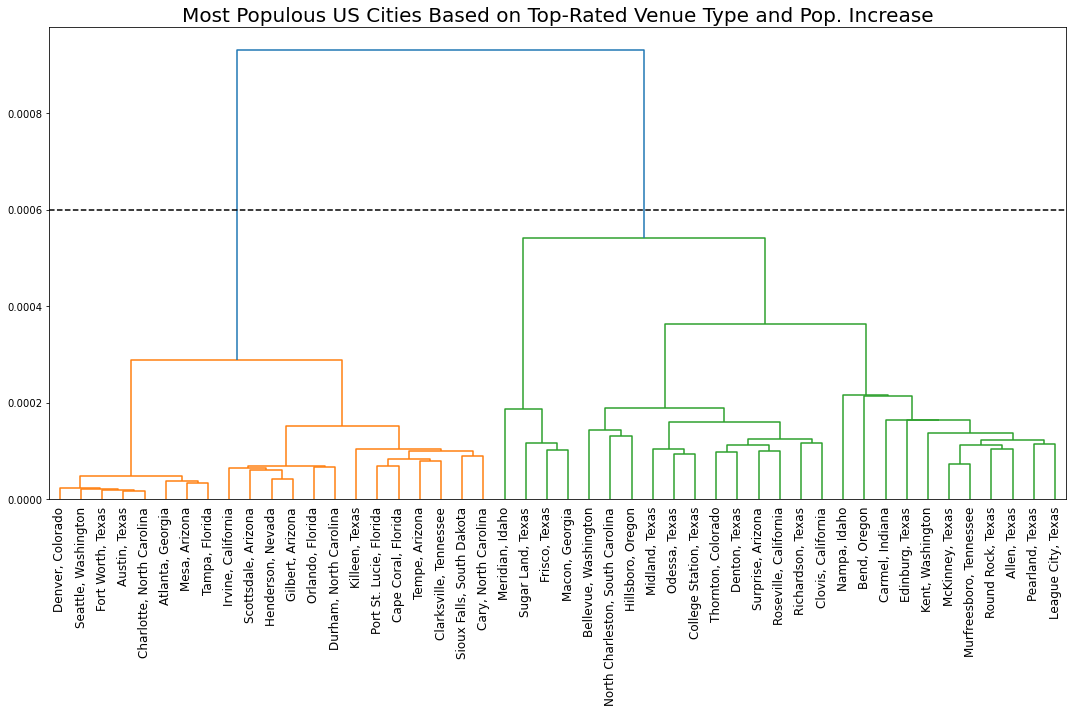

In [36]:
# Perform hierarchical clustering among most populous US cities with highest % increase included in features
import scipy.cluster.hierarchy as shc

def llf(id):
    return '%s' % (features_df.index[id])

plt.figure(figsize = (15, 10))
plt.title('Most Populous US Cities Based on Top-Rated Venue Type and Pop. Increase', fontsize=20)
dend = shc.dendrogram(shc.linkage(data_scaled_w_pop, method='ward'), leaf_label_func=llf, leaf_font_size=12)
plt.axhline(y=0.0006, color='k', linestyle='--')
plt.tight_layout()

plt.savefig('venue_and_pop_dendrogram.png')

plt.show()

Drawing colored boxes around the clusters:

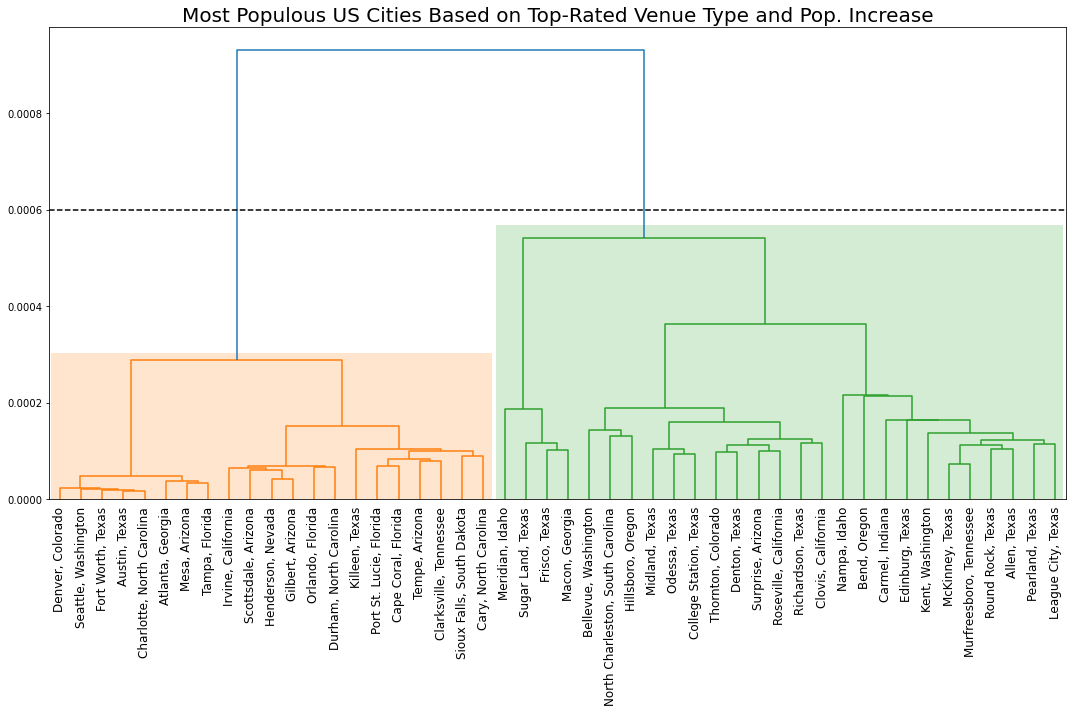

In [37]:
fig, ax = plt.subplots(1, 1, figsize = (15, 10))
plt.title('Most Populous US Cities Based on Top-Rated Venue Type and Pop. Increase', fontsize=20)
dend = shc.dendrogram(shc.linkage(data_scaled_w_pop, method='ward'), leaf_label_func=llf, leaf_font_size=12)
plt.axhline(y=0.0006, color='k', linestyle='--')
for coll in ax.collections[:-1]:  # the last collection is the ungrouped level
    xmin, xmax = np.inf, -np.inf
    ymax = -np.inf
    for p in coll.get_paths():
        box = p.get_extents()
        (x0, _), (x1, y1) = p.get_extents().get_points()
        xmin = min(xmin, x0)
        xmax = max(xmax, x1)
        ymax = max(ymax, y1)
    rec = plt.Rectangle((xmin - 4, 0), xmax - xmin + 8, ymax*1.05,
                        facecolor=coll.get_color()[0], alpha=0.2, edgecolor="none")
    ax.add_patch(rec)

plt.tight_layout()

plt.savefig('venue_and_pop_dendrogram_shaded.png')

plt.show()

The main, right-most cluster contains a sub-cluster in its lower-left corner in the dendrogram. This sub-cluster consists of five cities: Denver, CO; Seattle, WA; Charlotte, NC; Austin, TX; and Fort Worth, TX. Each of these cities appear to have the closest similarity since all of their links have a small and similar height in the dendrogram. For this reason, we explore these five cities further. First we check to see how the dendrogram changes when the population demographics are removed to ensure that we have fairly similar top rated venues around the respective city centers.

In [38]:
# investigate how the dendrogram changes without population demographics
data_scaled_no_pop = normalize(features_df.drop(columns=['2020 Estimate', '% Change (Pop)']))
data_scaled_no_pop = pd.DataFrame(data_scaled_no_pop, columns=features_df.drop(columns=['2020 Estimate', '% Change (Pop)']).columns)

In [39]:
data_scaled_no_pop.head()

,American Restaurant,Art Museum,BBQ Joint,Bar,Beer Bar,Bookstore,Bridge,Burger Joint,Café,Capitol Building,...,Fair,Winery,Automotive Shop,Chiropractor,Government Building,Polish Restaurant,Travel & Transport,Hawaiian Restaurant,Fondue Restaurant,Recreation Center
0,0.199557,0.066519,0.066519,0.133038,0.066519,0.066519,0.066519,0.066519,0.133038,0.133038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.223607,0.167705,0.055902,0.111803,0.167705,0.000000,0.000000,0.223607,0.111803,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.250982,0.062746,0.250982,0.062746,0.062746,0.062746,0.000000,0.125491,0.062746,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.128037,0.128037,0.000000,0.064018,0.064018,0.192055,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.417029,0.052129,0.000000,0.156386,0.000000,0.052129,0.000000,0.104257,0.156386,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


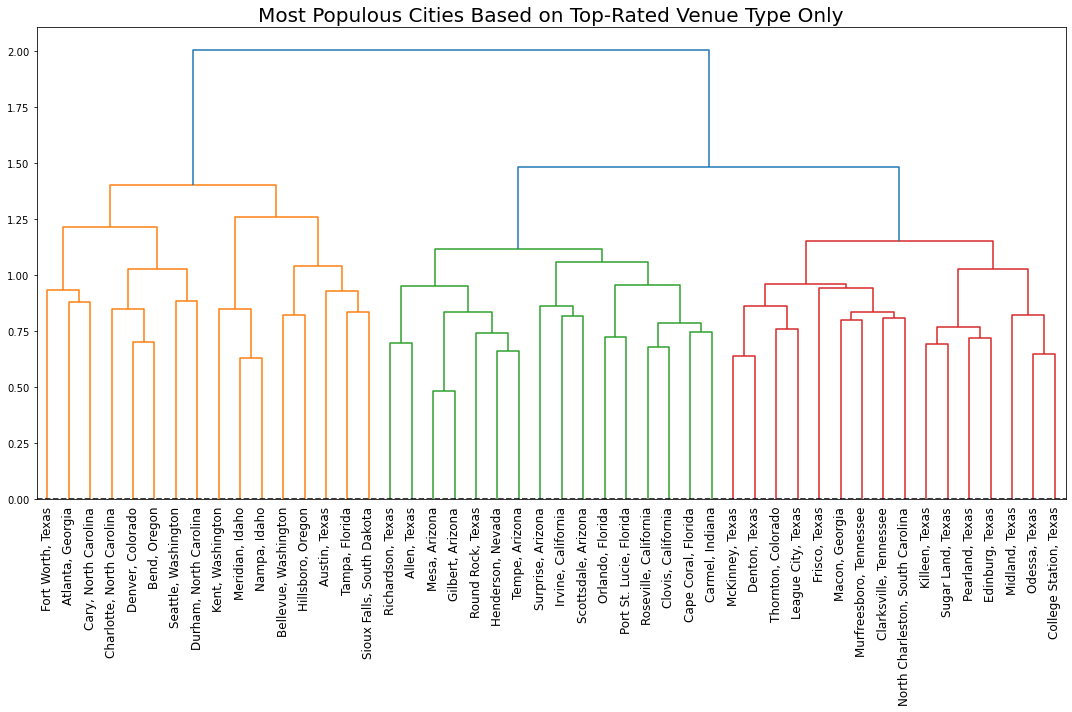

In [40]:
# Perform hierarchical clustering among most populous US cities without pop parameters (venue data as features only)

plt.figure(figsize = (15, 10))
plt.title('Most Populous Cities Based on Top-Rated Venue Type Only', fontsize=20)
dend = shc.dendrogram(shc.linkage(data_scaled_no_pop, method='ward'), leaf_label_func=llf, leaf_font_size=12)
plt.axhline(y=0.0006, color='k', linestyle='--')

plt.tight_layout()

plt.savefig('venue_dendrogram.png')

plt.show()

Comparing the linkage height of the five cities: Seattle, WA; Denver, CO; Charlotte, NC; Austin, TX; and Fort Worth, TX; we see that these cities are fairly similar in top rated venue type. Therefore, we cluster the top rated venues for each city to see which venues appear to be most common amongst them. We cluster venues within each city using k-Means.

### Mapping Similar Cities by Postal Code

#### Denver, Colorado

In [41]:
cities_dfs['Denver, Colorado'].head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Denver Biscuit Co. @ Stanley,Comfort Food Restaurant,2501 Dallas St,39.752841,-104.877418,"[{'label': 'display', 'lat': 39.75284135445655...",826,80010,US,Aurora,CO,United States,"[2501 Dallas St, Aurora, CO 80010, United States]",NaN,NaN,589e6be4f16bb565085def3f
1,Stanley Marketplace,Shopping Plaza,2501 Dallas St,39.752868,-104.877429,"[{'label': 'display', 'lat': 39.75286764713476...",823,80010,US,Aurora,CO,United States,"[2501 Dallas St (E. 25th Ave.), Aurora, CO 800...",E. 25th Ave.,Northwest Aurora,54244df9498e4eeeb346f0a2
2,Comida @ Stanley,Mexican Restaurant,NaN,39.752996,-104.877904,"[{'label': 'display', 'lat': 39.75299614889717...",800,80010,US,Aurora,CO,United States,"[Aurora, CO 80010, United States]",NaN,NaN,585441dadebdf67a4d0e5b13
3,Station 26 Brewing Company,Brewery,7045 E 38th Ave,39.769459,-104.905971,"[{'label': 'display', 'lat': 39.76945923824451...",2459,80207,US,Denver,CO,United States,"[7045 E 38th Ave, Denver, CO 80207, United Sta...",NaN,NaN,527e84dc498e05d392436ac9
4,Chick-fil-A,Fast Food Restaurant,3601 Quebec St,39.767780,-104.903838,"[{'label': 'display', 'lat': 39.7677796, 'lng'...",2216,80207,US,Denver,CO,United States,"[3601 Quebec St, Denver, CO 80207, United States]",NaN,NaN,56cb604acd10b93123b7a960


In [ ]:
cities_maps['Denver, Colorado'].save('denver_venue.html')
cities_maps['Denver, Colorado']

Identifying missing postal codes:

In [43]:
cities_dfs['Denver, Colorado'][cities_dfs['Denver, Colorado']['postalCode'].isnull()]

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
61,Great Divide Barrel Bar,Brewery,1812 35th St,39.770444,-104.978987,"[{'label': 'display', 'lat': 39.77044406263746...",8549,NaN,US,Denver,CO,United States,"[1812 35th St (Brighton Blvd.), Denver, CO, Un...",Brighton Blvd.,NaN,557c84fb498e8dd042b88d97


In [44]:
# import Nominatim to identify zip code of missing venue zips
from geopy.geocoders import Nominatim
  
# initialize Nominatim API 
geolocator = Nominatim(user_agent="denver_explorer")
  
# assign venue address input and get location info
place = cities_dfs['Denver, Colorado'].loc[61, 'address'] + ', Denver, Colorado'
location = geolocator.geocode(place)
  
# traverse the data
data = location.raw
loc_data = data['display_name'].split()
print("Full Location")
print(loc_data)
print("Zip code : ",loc_data[-3])

Full Location
['Great', 'Divide', 'Barrel', 'Bar,', '1812,', '35th', 'Street,', 'Five', 'Points,', 'Denver,', 'Denver', 'County,', 'Colorado,', '80216,', 'United', 'States']
Zip code :  80216,


Updating dataframe so no missing postal codes exist:

In [45]:
cities_dfs['Denver, Colorado'].loc[61, 'postalCode'] = loc_data[-3].replace(',', '')
cities_dfs['Denver, Colorado'].loc[61, 'postalCode']

'80216'

In [46]:
cities_dfs['Denver, Colorado'][cities_dfs['Denver, Colorado']['postalCode'].isnull()]

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id


In [47]:
denver_df = cities_dfs['Denver, Colorado'][['name', 'categories', 'lat', 'lng', 'postalCode']]
denver_df.head()

,name,categories,lat,lng,postalCode
0,Denver Biscuit Co. @ Stanley,Comfort Food Restaurant,39.752841,-104.877418,80010
1,Stanley Marketplace,Shopping Plaza,39.752868,-104.877429,80010
2,Comida @ Stanley,Mexican Restaurant,39.752996,-104.877904,80010
3,Station 26 Brewing Company,Brewery,39.769459,-104.905971,80207
4,Chick-fil-A,Fast Food Restaurant,39.767780,-104.903838,80207


In [48]:
denver_grouped_zip = denver_df.groupby('postalCode').count()
denver_grouped_zip

,name,categories,lat,lng
postalCode,,,,
80010,3,3,3,3
80011,2,2,2,2
80012,3,3,3,3
80022,2,2,2,2
80045,1,1,1,1
80202,1,1,1,1
80203,7,7,7,7
80204,1,1,1,1
80205,25,25,25,25


In [49]:
print('There are {} unique categories.'.format(len(denver_df['categories'].unique())))

There are 53 unique categories.


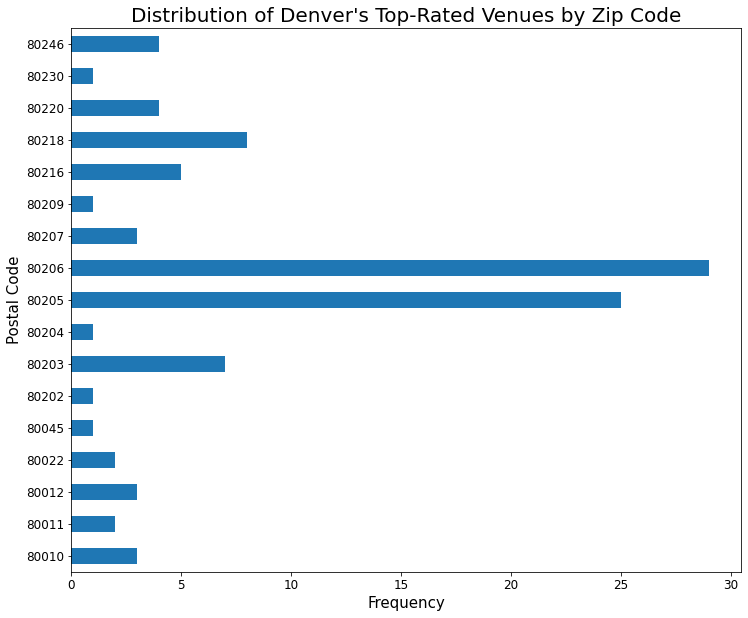

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax = denver_grouped_zip['categories'].plot(kind='barh', fontsize=12)
ax.set_title('Distribution of Denver\'s Top-Rated Venues by Zip Code', fontsize=20)
ax.set_xlabel('Frequency', fontsize=15)
ax.set_ylabel('Postal Code', fontsize=15)

plt.savefig('Denver_Distr_by_zip.png')

plt.show()

The most popular venue areas appear to be those located within the boundary of postal codes $80205$ and $80206$ with $76107$. Both ZIP codes appear to be solid candidates.

Re-indexing dataframe:

In [51]:
denver_grouped_zip = denver_df.groupby('postalCode').count()
denver_grouped_zip = denver_grouped_zip.reset_index()
denver_grouped_zip

,postalCode,name,categories,lat,lng
0,80010,3,3,3,3
1,80011,2,2,2,2
2,80012,3,3,3,3
3,80022,2,2,2,2
4,80045,1,1,1,1
5,80202,1,1,1,1
6,80203,7,7,7,7
7,80204,1,1,1,1
8,80205,25,25,25,25
9,80206,29,29,29,29


Creating choropleth map by zip code boundary.

GeoJSON obtained from https://github.com/OpenDataDE/State-zip-code-GeoJSON.

In [ ]:
denver_zip_map = folium.Map(location=[high_influx_df.loc[high_influx_df['City'] == 'Denver', 'Lat'], 
                                  high_influx_df.loc[high_influx_df['City'] == 'Denver','Long']],
                        zoom_start=11)

denver_grouped_zip['postalCode'] = denver_grouped_zip['postalCode'].astype('str')

folium.Choropleth(geo_data='co_colorado_zip_codes_geo.min.json',
             data=denver_grouped_zip, # my dataset
             columns=['postalCode', 'categories'], # zip code is here for matching the geojson zipcode, sales price is the column that changes the color of zipcode areas
             key_on='feature.properties.ZCTA5CE10', # this path contains zipcodes in str type, this zipcodes should match with our ZIP CODE column
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='categories').add_to(denver_zip_map)

denver_zip_map.save('denver_choropleth_zip.html')
denver_zip_map

The two most popular ZIP codes appear to be $80205$ and $80206$. These two ZIP code boundaries are right next to each other and are clearly visible in dark purple above. These are the areas in Denver, Colorado that are recommended to be investigated further by Company X.

### Seattle, Washington

In [53]:
cities_dfs['Seattle, Washington'].head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Seattle Center Playground,Playground,305 Harrison St,47.621869,-122.349254,"[{'label': 'display', 'lat': 47.62186859560178...",215,98109,US,Seattle,WA,United States,"[305 Harrison St, Seattle, WA 98109, United St...",NaN,NaN,555fca23498ebf779538a1e9
1,Chihuly Garden and Glass,Art Museum,305 Harrison St,47.620534,-122.350277,"[{'label': 'display', 'lat': 47.62053407471116...",62,98109,US,Seattle,WA,United States,"[305 Harrison St (at Seattle Center), Seattle,...",at Seattle Center,Lower Queen Anne,4f2334b8e4b0085e48b153c0
2,Seattle Center,Plaza,305 Harrison St,47.622190,-122.351475,"[{'label': 'display', 'lat': 47.62219030628736...",267,98109,US,Seattle,WA,United States,"[305 Harrison St (at 5th Ave), Seattle, WA 981...",at 5th Ave,NaN,42e18880f964a52066261fe3
3,Space Needle: Observation Deck,Scenic Lookout,400 Broad St,47.620515,-122.349330,"[{'label': 'display', 'lat': 47.6205147692609,...",76,98109,US,Seattle,WA,United States,"[400 Broad St, Seattle, WA 98109, United States]",NaN,NaN,4c3602ab93db0f475f511d92
4,MoPOP (Museum of Pop Culture (MoPOP)),Museum,325 5th Ave N,47.621526,-122.348054,"[{'label': 'display', 'lat': 47.621526, 'lng':...",224,98109,US,Seattle,WA,United States,"[325 5th Ave N (at Harrison St), Seattle, WA 9...",at Harrison St,NaN,43601880f964a5202d291fe3


In [ ]:
cities_maps['Seattle, Washington'].save('seattle_venues.html')
cities_maps['Seattle, Washington']

In [55]:
cities_dfs['Seattle, Washington'][cities_dfs['Seattle, Washington']['postalCode'].isnull()]

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id


In [56]:
seattle_df = cities_dfs['Seattle, Washington'][['name', 'categories', 'lat', 'lng', 'postalCode']]
seattle_df.head()

,name,categories,lat,lng,postalCode
0,Seattle Center Playground,Playground,47.621869,-122.349254,98109
1,Chihuly Garden and Glass,Art Museum,47.620534,-122.350277,98109
2,Seattle Center,Plaza,47.622190,-122.351475,98109
3,Space Needle: Observation Deck,Scenic Lookout,47.620515,-122.349330,98109
4,MoPOP (Museum of Pop Culture (MoPOP)),Museum,47.621526,-122.348054,98109


In [57]:
seattle_grouped_zip = seattle_df.groupby('postalCode').count()
seattle_grouped_zip

,name,categories,lat,lng
postalCode,,,,
98101,21,21,21,21
98102,6,6,6,6
98103,6,6,6,6
98104,6,6,6,6
98109,20,20,20,20
98112,5,5,5,5
98119,4,4,4,4
98121,13,13,13,13
98122,18,18,18,18


In [58]:
print('There are {} unique categories.'.format(len(seattle_df['categories'].unique())))

There are 62 unique categories.


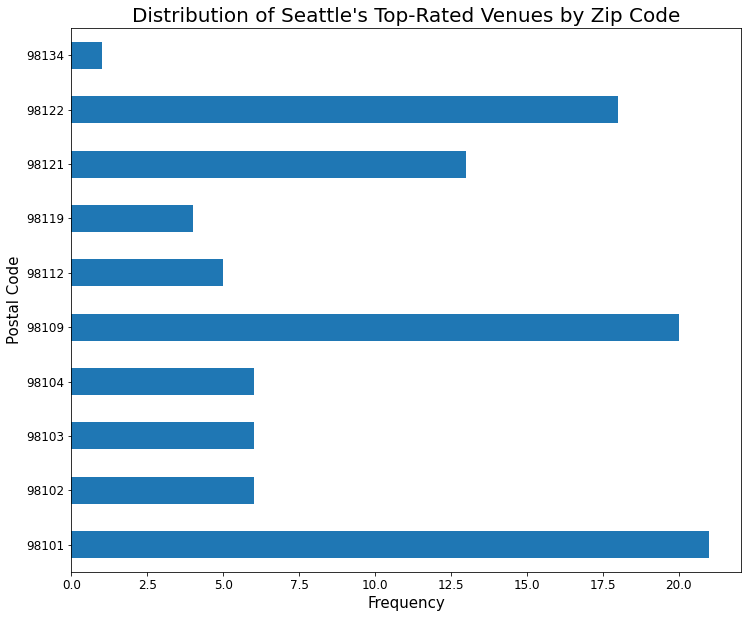

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax = seattle_grouped_zip['categories'].plot(kind='barh', fontsize=12)
ax.set_title('Distribution of Seattle\'s Top-Rated Venues by Zip Code', fontsize=20)
ax.set_xlabel('Frequency', fontsize=15)
ax.set_ylabel('Postal Code', fontsize=15)

plt.savefig('seattle_distr_by_zip.png')

plt.show()

There is a handful of good postal code area candidates in Seattle, WA. The most popular venue areas appear to be those located within the boundary of postal codes $98101$, $98109$, $98121$, and $98122$.

Re-indexing dataframe:

In [60]:
seattle_grouped_zip = seattle_df.groupby('postalCode').count()
seattle_grouped_zip = seattle_grouped_zip.reset_index()
seattle_grouped_zip

,postalCode,name,categories,lat,lng
0,98101,21,21,21,21
1,98102,6,6,6,6
2,98103,6,6,6,6
3,98104,6,6,6,6
4,98109,20,20,20,20
5,98112,5,5,5,5
6,98119,4,4,4,4
7,98121,13,13,13,13
8,98122,18,18,18,18
9,98134,1,1,1,1


Creating choropleth map by zip code boundary.

GeoJSON obtained from https://github.com/OpenDataDE/State-zip-code-GeoJSON.

In [ ]:
seattle_zip_map = folium.Map(location=[high_influx_df.loc[high_influx_df['City'] == 'Seattle', 'Lat'], 
                                  high_influx_df.loc[high_influx_df['City'] == 'Seattle','Long']],
                        zoom_start=12)

seattle_grouped_zip['postalCode'] = seattle_grouped_zip['postalCode'].astype('str')

folium.Choropleth(geo_data='wa_washington_zip_codes_geo.min.json',
             data=seattle_grouped_zip, # my dataset
             columns=['postalCode', 'categories'], # zip code is here for matching the geojson zipcode, sales price is the column that changes the color of zipcode areas
             key_on='feature.properties.ZCTA5CE10', # this path contains zipcodes in str type, this zipcodes should match with our ZIP CODE column
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Popular Venues').add_to(seattle_zip_map)

seattle_zip_map.save('seattle_choropleth_zip.html')
seattle_zip_map.save('seattle_choropleth_zip.png')
seattle_zip_map

The most popular ZIP codes here appear to be $98101$, $98109$, $98121$, and $98122$, and their boundaries appear in darker purple in the above choropleth above. Company X should investigate these areas in Seattle, Washington.

### Charlotte, North Carolina

In [62]:
cities_dfs['Charlotte, North Carolina'].head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Duke Mansion,Bed & Breakfast,400 Hermitage Rd,35.201550,-80.827493,"[{'label': 'display', 'lat': 35.20154972108919...",285,28207,US,Charlotte,NC,United States,"[400 Hermitage Rd, Charlotte, NC 28207, United...",NaN,NaN,4b05863af964a520355922e3
1,Freedom Park,Park,1900 East Blvd,35.192609,-80.843485,"[{'label': 'display', 'lat': 35.19260875441761...",1477,28203,US,Charlotte,NC,United States,"[1900 East Blvd (btwn S Kings & Lombardy), Cha...",btwn S Kings & Lombardy,NaN,4b058642f964a520ab5a22e3
2,Viva Chicken Elizabeth Avenue,Peruvian Restaurant,1617 Elizabeth Ave,35.213407,-80.825966,"[{'label': 'display', 'lat': 35.21340676476259...",1536,28204,US,Charlotte,NC,United States,"[1617 Elizabeth Ave, Charlotte, NC 28204, Unit...",NaN,NaN,5101b86c3950fe1fc6f0e85f
3,Mama Ricotta's,Italian Restaurant,601 S Kings Dr Ste Aa,35.210081,-80.836012,"[{'label': 'display', 'lat': 35.21008074477649...",1248,28204,US,Charlotte,NC,United States,[601 S Kings Dr Ste Aa (at Charlottetowne Dr.)...,at Charlottetowne Dr.,NaN,4b0d9ebdf964a5206d4c23e3
4,Duck Donuts,Donut Shop,1710 Kenilworth Avenue,35.202624,-80.844419,"[{'label': 'display', 'lat': 35.2026242, 'lng'...",1343,28203,US,Charlotte,NC,United States,"[1710 Kenilworth Avenue, Charlotte, NC 28203, ...",NaN,NaN,55f42d32498ecd91ca74af81


In [ ]:
cities_maps['Charlotte, North Carolina'].save('charlotte_venues.html')
cities_maps['Charlotte, North Carolina']

In [64]:
charlotte_null_zips = cities_dfs['Charlotte, North Carolina'][cities_dfs['Charlotte, North Carolina']['postalCode'].isnull()]
charlotte_null_zips

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
29,Little Sugar Creek Greenway,Park,Westfield,35.176561,-80.845998,"[{'label': 'display', 'lat': 35.17656115063397...",2987,NaN,US,Charlotte,NC,United States,"[Westfield, Charlotte, NC, United States]",NaN,NaN,4c76d5e107818cfa0f9ad2e3
40,300 East,American Restaurant,300 East Blvd,35.210571,-80.856556,"[{'label': 'display', 'lat': 35.21057084410842...",2686,NaN,US,Charlotte,NC,United States,"[300 East Blvd (Cleveland Ave), Charlotte, NC,...",Cleveland Ave,NaN,4b05863ef964a520ee5922e3


In [65]:
# initialize Nominatim API 
geolocator = Nominatim(user_agent="charlotte_explorer")

# assign venue address input and get location info
for i in charlotte_null_zips.index:
    place = cities_dfs['Charlotte, North Carolina'].loc[i, 'address'] + ', Charlotte, North Carolina'
    location = geolocator.geocode(place)
    
    # traverse the data
    data = location.raw
    loc_data = data['display_name'].split()
    print("Full Location")
    print(loc_data)
    print("Zip code : ",loc_data[-3])

Full Location
['Westfield', 'Shopping', 'Center,', 'Oakview', 'Terrace,', 'Charlotte,', 'Mecklenburg', 'County,', 'North', 'Carolina,', 'United', 'States']
Zip code :  Carolina,
Full Location
['300', 'East,', '300,', 'East', 'Boulevard,', 'South', 'End,', 'Charlotte,', 'Mecklenburg', 'County,', 'North', 'Carolina,', '28203,', 'United', 'States']
Zip code :  28203,


In [66]:
cities_dfs['Charlotte, North Carolina'].loc[29, 'postalCode'] = '28204'
cities_dfs['Charlotte, North Carolina'].loc[48, 'postalCode'] = loc_data[-3].replace(',', '')

In [67]:
charlotte_df = cities_dfs['Charlotte, North Carolina'][['name', 'categories', 'lat', 'lng', 'postalCode']]
charlotte_df.head()

,name,categories,lat,lng,postalCode
0,Duke Mansion,Bed & Breakfast,35.201550,-80.827493,28207
1,Freedom Park,Park,35.192609,-80.843485,28203
2,Viva Chicken Elizabeth Avenue,Peruvian Restaurant,35.213407,-80.825966,28204
3,Mama Ricotta's,Italian Restaurant,35.210081,-80.836012,28204
4,Duck Donuts,Donut Shop,35.202624,-80.844419,28203


In [68]:
charlotte_grouped_zip = charlotte_df.groupby('postalCode').count()
charlotte_grouped_zip

,name,categories,lat,lng
postalCode,,,,
28202,26,26,26,26
28203,33,33,33,33
28204,12,12,12,12
28205,9,9,9,9
28206,2,2,2,2
28207,1,1,1,1
28209,11,11,11,11
28211,3,3,3,3
28217,1,1,1,1


In [69]:
print('There are {} unique categories.'.format(len(charlotte_df['categories'].unique())))

There are 64 unique categories.


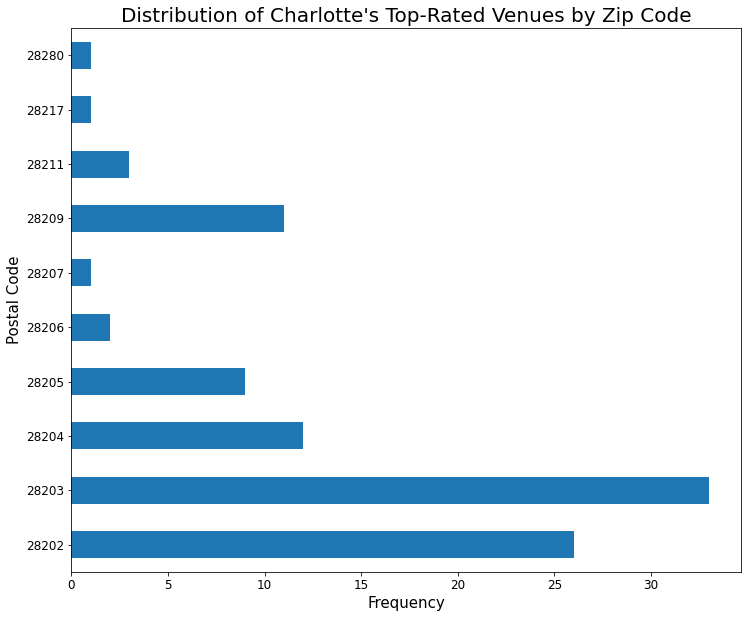

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax = charlotte_grouped_zip['categories'].plot(kind='barh', fontsize=12)
ax.set_title('Distribution of Charlotte\'s Top-Rated Venues by Zip Code', fontsize=20)
ax.set_xlabel('Frequency', fontsize=15)
ax.set_ylabel('Postal Code', fontsize=15)

plt.savefig('charlotte_distr_by_zip.png')

plt.show()

The most popular venue areas appear to be those located within the boundary of postal codes $28202$ and $28203$ with $76107$.

Re-indexing dataframe:

In [71]:
charlotte_grouped_zip = charlotte_df.groupby('postalCode').count()
charlotte_grouped_zip = charlotte_grouped_zip.reset_index()
charlotte_grouped_zip

,postalCode,name,categories,lat,lng
0,28202,26,26,26,26
1,28203,33,33,33,33
2,28204,12,12,12,12
3,28205,9,9,9,9
4,28206,2,2,2,2
5,28207,1,1,1,1
6,28209,11,11,11,11
7,28211,3,3,3,3
8,28217,1,1,1,1
9,28280,1,1,1,1


Creating choropleth map by zip code boundary.

GeoJSON obtained from https://github.com/OpenDataDE/State-zip-code-GeoJSON.

In [ ]:
charlotte_zip_map = folium.Map(location=[high_influx_df.loc[high_influx_df['City'] == 'Charlotte', 'Lat'], 
                                  high_influx_df.loc[high_influx_df['City'] == 'Charlotte','Long']],
                        zoom_start=12)

charlotte_grouped_zip['postalCode'] = charlotte_grouped_zip['postalCode'].astype('str')

folium.Choropleth(geo_data='nc_north_carolina_zip_codes_geo.min.json',
             data=charlotte_grouped_zip, # my dataset
             columns=['postalCode', 'categories'], # zip code is here for matching the geojson zipcode, sales price is the column that changes the color of zipcode areas
             key_on='feature.properties.ZCTA5CE10', # this path contains zipcodes in str type, this zipcodes should match with our ZIP CODE column
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Popular Venues').add_to(charlotte_zip_map)

charlotte_zip_map.save('charlotte_choropleth_zip.html')
charlotte_zip_map

The most popular ZIP codes here appear to be $28202$, and $28203$, and their boundaries appear in darker purple in the above choropleth above. Company X should investigate these areas in Charlotte, North Carolina.

### Austin, Texas

In [73]:
cities_dfs['Austin, Texas'].head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Hopfields,Gastropub,3110 Guadalupe St,30.298671,-97.740878,"[{'label': 'display', 'lat': 30.29867101720317...",889,78705,US,Austin,TX,United States,"[3110 Guadalupe St, Austin, TX 78705, United S...",NaN,NaN,4e1a2449aeb7eb0120dbf401
1,FoodHeads,Sandwich Place,616 W 34th St,30.300751,-97.740348,"[{'label': 'display', 'lat': 30.30075071906708...",931,78705,US,Austin,TX,United States,[616 W 34th St (btwn Guadalupe St. & King St.)...,btwn Guadalupe St. & King St.,NaN,4a06e4cbf964a52009731fe3
2,Via 313,Pizza Place,3016 Guadalupe St,30.297919,-97.741343,"[{'label': 'display', 'lat': 30.29791850205146...",863,78705,US,Austin,TX,United States,"[3016 Guadalupe St, Austin, TX 78705, United S...",NaN,NaN,56d4dfc8498e30f5748db0ed
3,Kerbey Lane Café,Café,3704 Kerbey Ln,30.308030,-97.750470,"[{'label': 'display', 'lat': 30.30803, 'lng': ...",895,78731,US,Austin,TX,United States,"[3704 Kerbey Ln, Austin, TX 78731, United States]",NaN,NaN,414f6f00f964a520f61c1fe3
4,Central Market,Gourmet Shop,4001 N Lamar Blvd,30.307610,-97.739876,"[{'label': 'display', 'lat': 30.3076098, 'lng'...",1290,78756,US,Austin,TX,United States,"[4001 N Lamar Blvd, Austin, TX 78756, United S...",NaN,NaN,436e9900f964a520e0291fe3


In [ ]:
cities_maps['Austin, Texas'].save('austin_venues.html')
cities_maps['Austin, Texas']

In [75]:
austin_null_zips = cities_dfs['Austin, Texas'][cities_dfs['Austin, Texas']['postalCode'].isnull()]
austin_null_zips

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
28,Texas Capitol Grounds,Field,NaN,30.273893,-97.740607,"[{'label': 'display', 'lat': 30.27389265053454...",3043,NaN,US,Austin,TX,United States,"[Austin, TX, United States]",NaN,NaN,4d8a30f199c2a1cd53508bd7
40,Mount Bonnell,Mountain,NaN,30.320932,-97.773316,"[{'label': 'display', 'lat': 30.3209317037736,...",3232,NaN,US,Austin,TX,United States,"[Austin, TX, United States]",NaN,NaN,58f39a7ef62f2b63ec305119
51,Lou Neff Point,Scenic Lookout,Lady Bird Lake,30.267198,-97.761780,"[{'label': 'display', 'lat': 30.26719807024510...",3823,NaN,US,Austin,TX,United States,"[Lady Bird Lake (Barton Springs Trail), Austin...",Barton Springs Trail,NaN,4b19a477f964a5200ce123e3
73,Pfluger Pedestrian Bridge,Bridge,1250 W. Riverside Dr.,30.265615,-97.755822,"[{'label': 'display', 'lat': 30.26561471739997...",3868,NaN,US,Austin,TX,United States,"[1250 W. Riverside Dr. (at S. Lamar Blvd.), Au...",at S. Lamar Blvd.,NaN,4b995135f964a5207d7235e3
91,Ladybird Lake Hike & Bike Trail (Rainey St.),Trail,NaN,30.258917,-97.740925,"[{'label': 'display', 'lat': 30.25891677216768...",4655,NaN,US,Austin,TX,United States,"[Austin, TX, United States]",NaN,NaN,4e88936c61afa8c25f422bd4


In [76]:
# initialize Nominatim API 
geolocator = Nominatim(user_agent="austin_explorer")

# assign venue address input and get location info
for i in austin_null_zips.index:
#     place = str(cities_dfs['Austin, Texas'].loc[i, 'address']) + ', Austin, Texas'
    location = geolocator.reverse((austin_null_zips.loc[i, 'lat'], austin_null_zips.loc[i, 'lng']))
    
    # traverse the data
    data = location.raw
    loc_data = data['display_name'].split()
    print("Full Location")
    print(loc_data)
    print("Zip code : ",loc_data[-3])

Full Location
['Heroes', 'of', 'the', 'Alamo,', 'State', 'Capitol', 'Driveway,', 'Medical', 'District,', 'Austin,', 'Travis', 'County,', 'Texas,', '78778,', 'United', 'States']
Zip code :  78778,
Full Location
['3800,', 'Mount', 'Bonnell', 'Road,', 'Balcones', 'Park,', 'Austin,', 'Travis', 'County,', 'Texas,', '78731,', 'United', 'States']
Zip code :  78731,
Full Location
['Lou', 'Neff', 'Point,', 'Lady', 'Bird', 'Lake', 'Hike', 'and', 'Bike', 'Trail,', 'Austin,', 'Travis', 'County,', 'Texas,', '78701,', 'United', 'States']
Zip code :  78701,
Full Location
['Pfluger', 'Pedestrian', 'Bridge,', 'West', 'Cesar', 'Chavez', 'Street,', 'Seaholm,', 'Austin,', 'Travis', 'County,', 'Texas,', '78703,', 'United', 'States']
Zip code :  78703,
Full Location
['Trail', 'of', 'Tejano', 'Legends,', 'Lady', 'Bird', 'Lake', 'Hike', 'and', 'Bike', 'Trail,', 'Rainey', 'Street', 'Historic', 'District,', 'Austin,', 'Travis', 'County,', 'Texas,', '78767,', 'United', 'States']
Zip code :  78767,


In [77]:
for i in austin_null_zips.index:
    cities_dfs['Austin, Texas'].loc[i, 'postalCode'] = loc_data[-3].replace(',', '')

In [78]:
austin_null_zips = cities_dfs['Austin, Texas'][cities_dfs['Austin, Texas']['postalCode'].isnull()]
austin_null_zips

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id


In [79]:
austin_df = cities_dfs['Austin, Texas'][['name', 'categories', 'lat', 'lng', 'postalCode']]
austin_df.head()

,name,categories,lat,lng,postalCode
0,Hopfields,Gastropub,30.298671,-97.740878,78705
1,FoodHeads,Sandwich Place,30.300751,-97.740348,78705
2,Via 313,Pizza Place,30.297919,-97.741343,78705
3,Kerbey Lane Café,Café,30.308030,-97.750470,78731
4,Central Market,Gourmet Shop,30.307610,-97.739876,78756


In [80]:
austin_grouped_zip = austin_df.groupby('postalCode').count()
austin_grouped_zip

,name,categories,lat,lng
postalCode,,,,
78701,28,28,28,28
78702,7,7,7,7
78703,17,17,17,17
78704,8,8,8,8
78705,6,6,6,6
78712,1,1,1,1
78722,5,5,5,5
78723,4,4,4,4
78731,2,2,2,2


In [81]:
print('There are {} unique categories.'.format(len(austin_df['categories'].unique())))

There are 61 unique categories.


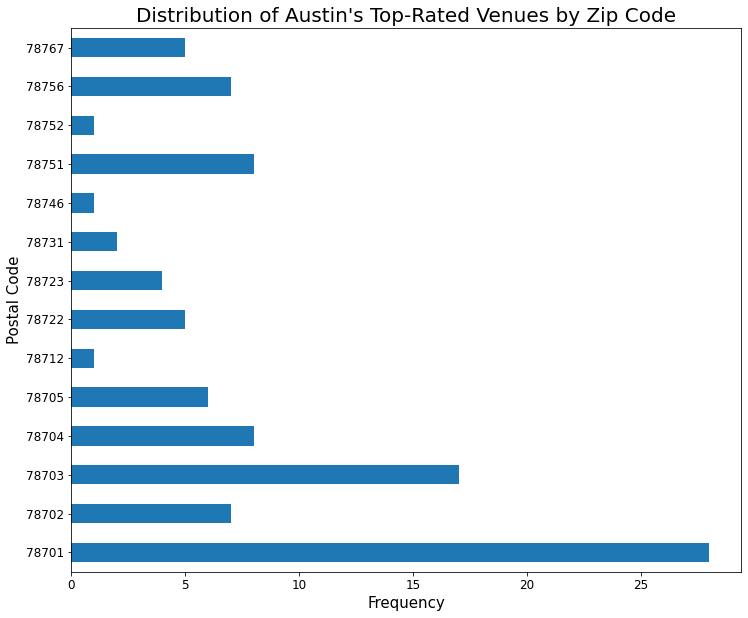

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax = austin_grouped_zip['categories'].plot(kind='barh', fontsize=12)
ax.set_title('Distribution of Austin\'s Top-Rated Venues by Zip Code', fontsize=20)
ax.set_xlabel('Frequency', fontsize=15)
ax.set_ylabel('Postal Code', fontsize=15)

plt.savefig('austin_distr_by_zip.png')

plt.show()

The most popular venue areas appear to be those located within the boundary of postal codes $78701$ and $76703$ with $78101$ being the clear winner.

Re-indexing dataframe:

In [83]:
austin_grouped_zip = austin_df.groupby('postalCode').count()
austin_grouped_zip = austin_grouped_zip.reset_index()
austin_grouped_zip

,postalCode,name,categories,lat,lng
0,78701,28,28,28,28
1,78702,7,7,7,7
2,78703,17,17,17,17
3,78704,8,8,8,8
4,78705,6,6,6,6
5,78712,1,1,1,1
6,78722,5,5,5,5
7,78723,4,4,4,4
8,78731,2,2,2,2
9,78746,1,1,1,1


Creating choropleth map by zip code boundary.

GeoJSON obtained from https://github.com/OpenDataDE/State-zip-code-GeoJSON.

In [ ]:
austin_zip_map = folium.Map(location=[high_influx_df.loc[high_influx_df['City'] == 'Austin', 'Lat'], 
                                  high_influx_df.loc[high_influx_df['City'] == 'Austin','Long']],
                        zoom_start=12)

austin_grouped_zip['postalCode'] = austin_grouped_zip['postalCode'].astype('str')

folium.Choropleth(geo_data='tx_texas_zip_codes_geo.min.json',
             data=austin_grouped_zip, # my dataset
             columns=['postalCode', 'categories'], # zip code is here for matching the geojson zipcode, sales price is the column that changes the color of zipcode areas
             key_on='feature.properties.ZCTA5CE10', # this path contains zipcodes in str type, this zipcodes should match with our ZIP CODE column
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Popular Venues').add_to(austin_zip_map)

austin_zip_map.save('austin_choropleth_zip.html')
austin_zip_map

The most popular ZIP code appears to be $78701$, and its boundary appears in dark purple in the above choropleth above. The second best ZIP code appears to be $78703$, which is the next darkest shade of purple. Company X should investigate these areas in Austin, Texas.

### Fort Worth, Texas

In [85]:
cities_dfs['Fort Worth, Texas'].head()

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Esperanza's Restaurant & Bakery,Mexican Restaurant,2122 N Main St,at NE 22nd St,32.784091,-97.348967,"[{'label': 'display', 'lat': 32.78409104530302...",954,76164,US,Fort Worth,TX,United States,"[2122 N Main St (at NE 22nd St), Fort Worth, T...",NaN,4b0ff7a0f964a520d86623e3
1,Coyote Drive-In,Drive-in Theater,223 Northeast 4th Street,NaN,32.764778,-97.335726,"[{'label': 'display', 'lat': 32.764778, 'lng':...",1741,76164,US,Fort Worth,TX,United States,"[223 Northeast 4th Street, Fort Worth, TX 7616...",Panther Island,517569b1498efc18c773c372
2,Joe T. Garcia's,Mexican Restaurant,2201 N Commerce St,at N.E. 22nd St.,32.784666,-97.348159,"[{'label': 'display', 'lat': 32.78466620186836...",923,76164,US,Fort Worth,TX,United States,"[2201 N Commerce St (at N.E. 22nd St.), Fort W...",NaN,4a762fcdf964a52084e21fe3
3,Trinity Trails,Trail,Taylor St,NaN,32.760717,-97.331057,"[{'label': 'display', 'lat': 32.76071688548088...",2304,76107,US,Fort Worth,TX,United States,"[Taylor St, Fort Worth, TX 76107, United States]",NaN,4e90648c30f81ec6ff74c135
4,El Asadero,Mexican Restaurant,1535 N Main St,NaN,32.780526,-97.348833,"[{'label': 'display', 'lat': 32.78052559465342...",828,76164,US,Fort Worth,TX,United States,"[1535 N Main St, Fort Worth, TX 76164, United ...",NaN,4ac0e64bf964a520e99420e3


In [ ]:
cities_maps['Fort Worth, Texas'].save('fort_worth_venues.html')
cities_maps['Fort Worth, Texas']

In [87]:
fort_worth_null_zips = cities_dfs['Fort Worth, Texas'][cities_dfs['Fort Worth, Texas']['postalCode'].isnull()]
fort_worth_null_zips

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id


In [88]:
fort_worth_df = cities_dfs['Fort Worth, Texas'][['name', 'categories', 'lat', 'lng', 'postalCode']]
fort_worth_df.head()

,name,categories,lat,lng,postalCode
0,Esperanza's Restaurant & Bakery,Mexican Restaurant,32.784091,-97.348967,76164
1,Coyote Drive-In,Drive-in Theater,32.764778,-97.335726,76164
2,Joe T. Garcia's,Mexican Restaurant,32.784666,-97.348159,76164
3,Trinity Trails,Trail,32.760717,-97.331057,76107
4,El Asadero,Mexican Restaurant,32.780526,-97.348833,76164


In [89]:
fort_worth_grouped_zip = fort_worth_df.groupby('postalCode').count()
fort_worth_grouped_zip

,name,categories,lat,lng
postalCode,,,,
76102,27,27,27,27
76104,10,10,10,10
76106,1,1,1,1
76107,44,44,44,44
76109,2,2,2,2
76110,1,1,1,1
76111,2,2,2,2
76117,1,1,1,1
76164,12,12,12,12


In [90]:
print('There are {} unique categories.'.format(len(fort_worth_df['categories'].unique())))

There are 55 unique categories.


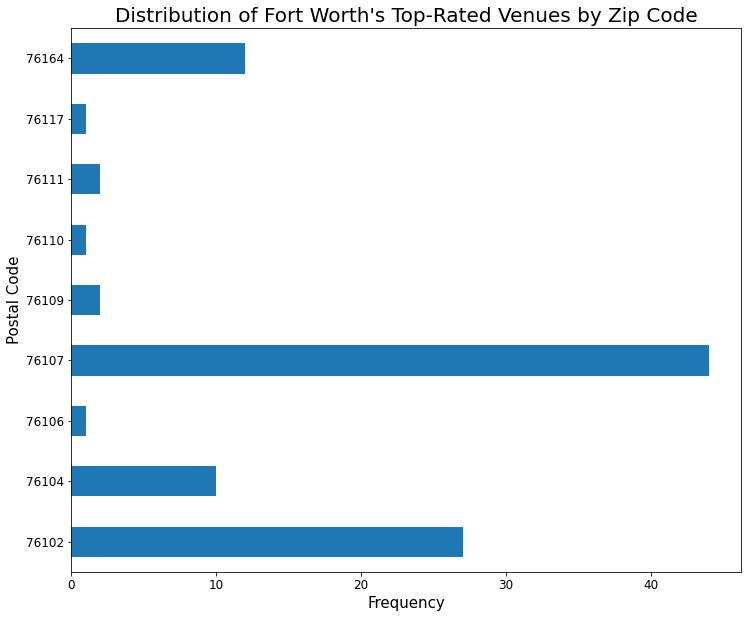

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax = fort_worth_grouped_zip['categories'].plot(kind='barh', fontsize=12)
ax.set_title('Distribution of Fort Worth\'s Top-Rated Venues by Zip Code', fontsize=20)
ax.set_xlabel('Frequency', fontsize=15)
ax.set_ylabel('Postal Code', fontsize=15)

plt.savefig('fort_worth_distr_by_zip.png')

plt.show()

The most popular venue areas appear to be those located within the boundary of postal codes $76102$ and $76107$ with $76107$ being the clear winner.

Re-indexing dataframe:

In [92]:
fort_worth_grouped_zip = fort_worth_df.groupby('postalCode').count()
fort_worth_grouped_zip = fort_worth_grouped_zip.reset_index()
fort_worth_grouped_zip

,postalCode,name,categories,lat,lng
0,76102,27,27,27,27
1,76104,10,10,10,10
2,76106,1,1,1,1
3,76107,44,44,44,44
4,76109,2,2,2,2
5,76110,1,1,1,1
6,76111,2,2,2,2
7,76117,1,1,1,1
8,76164,12,12,12,12


Creating choropleth map by zip code boundary.

GeoJSON obtained from https://github.com/OpenDataDE/State-zip-code-GeoJSON.

In [ ]:
fort_worth_zip_map = folium.Map(location=[high_influx_df.loc[high_influx_df['City'] == 'Fort Worth', 'Lat'], 
                                  high_influx_df.loc[high_influx_df['City'] == 'Fort Worth','Long']],
                        zoom_start=12)

fort_worth_grouped_zip['postalCode'] = fort_worth_grouped_zip['postalCode'].astype('str')

folium.Choropleth(geo_data='tx_texas_zip_codes_geo.min.json',
             data=fort_worth_grouped_zip, # my dataset
             columns=['postalCode', 'categories'], # zip code is here for matching the geojson zipcode, sales price is the column that changes the color of zipcode areas
             key_on='feature.properties.ZCTA5CE10', # this path contains zipcodes in str type, this zipcodes should match with our ZIP CODE column
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Popular Venues').add_to(fort_worth_zip_map)

fort_worth_zip_map.save('fort_worth_choropleth_zip.html')
fort_worth_zip_map

The most popular ZIP code here appears to be $76107$, and its boundary appears in dark purple in the above choropleth above. The second best ZIP code appears to be $76102$ which is the next darkest shade of purple. Company X should investigate these areas in Fort Worth, Texas.

### End of Notebook